In [36]:
import numpy as np
import pandas as pd

import gc
import time
import warnings


import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.gridspec as gridspec 
import matplotlib.gridspec as gridspec 

import plotly.offline as pyo
from plotly.graph_objs import *
import plotly.graph_objs as go

import imageio
import folium
import folium.plugins as plugins


import networkx as nx
import heapq  # for getting top n number of things from list,dict


start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
warnings.filterwarnings("ignore")
pyo.init_notebook_mode()

%matplotlib inline

from pymongo import MongoClient
import sqlite3 as sql
import mpl_toolkits


import unicodedata
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
import nltk
from collections import Counter
from nltk import pos_tag

from sklearn.feature_extraction.text  import TfidfVectorizer

from sklearn.cluster import KMeans
import numpy as np
from wordcloud                        import WordCloud
from sklearn.metrics                  import silhouette_samples, silhouette_score
import matplotlib.cm      as cm
import requests
from sklearn import cluster

Database "RDB" has been created and is accessed using SQLite3. RDB was created by combining the reviews and businesss JSON files for the Kaggle dataset. All businesses that are not restaurant and food related have been filtered out using a DB Browser

In [2]:
RDB =  sql.connect("RDB")

Initial EDA

In [3]:
query ='''SELECT city||state , count(text) FROM Review_Business GROUP BY city||state ORDER BY count(text)'''
city_state_review_count = pd.read_sql_query(query,RDB)

In [7]:
city_state_review_count.tail()

city||state  count(text)
904   CharlotteNC       283413
905  ScottsdaleAZ       294723
906     TorontoON       484296
907     PhoenixAZ       551274
908   Las VegasNV      1615064

In [8]:
city_state_review_count.loc[762:742:-1]

city||state  count(text)
762     Pointe-ClaireQC         1089
761          Tega CaySC         1087
760            LorainOH         1077
759      West MifflinPA         1067
758           AirdrieAB         1060
757    Shaker HeightsOH         1045
756        KannapolisNC         1040
755         WestmountQC         1024
754            DallasTX         1016
753              YorkON          992
752            DorvalQC          988
751            EuclidOH          973
750  Highland HeightsOH          961
749           ChardonOH          959
748          WaunakeeWI          940
747            AnthemAZ          937
746     Olmsted FallsOH          911
745       Mount HollyNC          886
744             MapleON          868
743          BellevuePA          868
742  North RidgevilleOH          861

Graph counts of each city

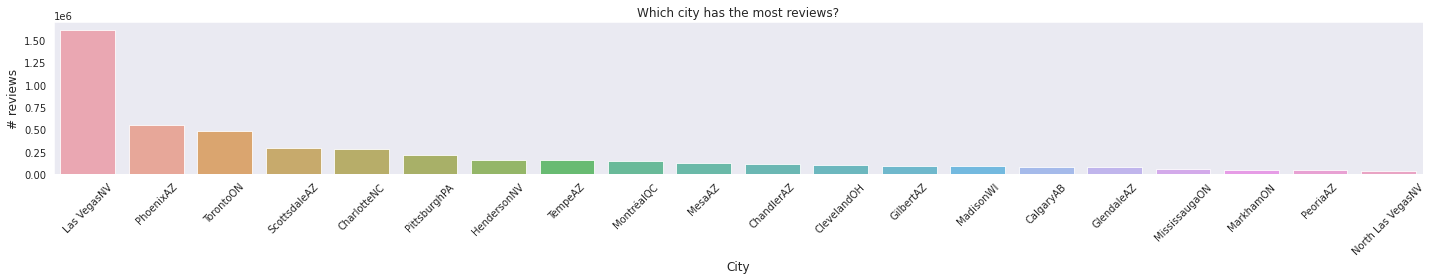

In [9]:
plt.figure(figsize=(20,4))
ax = sns.barplot(city_state_review_count.nlargest(20,['count(text)'])['city||state'], city_state_review_count.nlargest(20,['count(text)'])['count(text)'], alpha=0.8)
plt.title("Which city has the most reviews?")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('# reviews', fontsize=12)
plt.xlabel('City', fontsize=12)
plt.tight_layout()
plt.savefig('img/citycount.png')

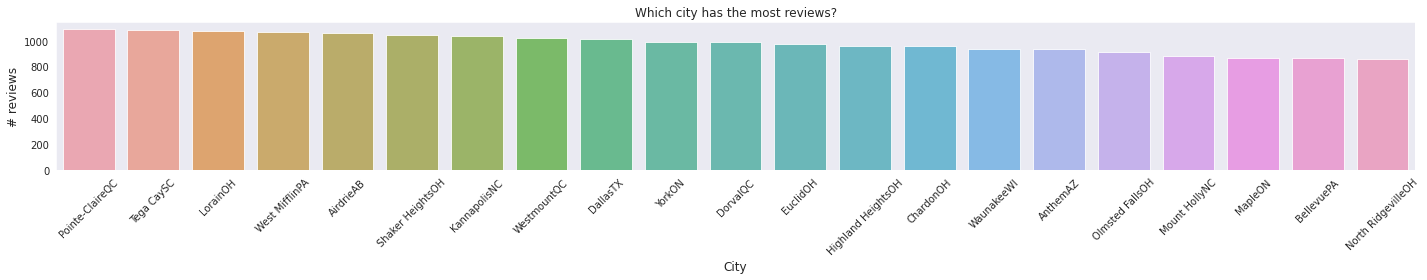

In [10]:
plt.figure(figsize=(20,4))
ax = sns.barplot(city_state_review_count.loc[762:742:-1]['city||state'],city_state_review_count.loc[762:742:-1]['count(text)'], alpha=0.8)
plt.title("Which city has the most reviews?")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('# reviews', fontsize=12)
plt.xlabel('City', fontsize=12)
plt.tight_layout()
plt.savefig('img/citycount2.png')

Handle a smaller dataset, this saves each individual city into separate .csv files

In [12]:
for i in city_state_review_count['city||state'][100:103]:
    query = f"SELECT * FROM Review_Business WHERE city||state = '{str(i)}' "
    j = pd.read_sql_query(query,RDB)
    j.to_csv(f'Cities/{str(i)}.csv')
    print(j.shape)
    print('completed!')
    

(4, 17)
completed!
(4, 17)
completed!
(4, 17)
completed!


Chose specific City Pointe Claire QC

In [13]:
# Pandas Dataframe of all reviews for Pointe Claire QC 
PointeClaireQC_all = pd.read_csv('Cities/Pointe-ClaireQC.csv',index_col=0)
# Declare variable consisting of all reviews in one dataframe for processing 
PointeClaireQC = PointeClaireQC_all['text'].tolist()

In [16]:
PointeClaireQC_all.head()

review_id             business_id  useful  funny  cool  \
0  fZbEYUum6WPUEhTi-2RO_Q  Xz2GP6UPMQu22EB_76nZKw       1      0     1   
1  F-xqpheSfCTp6xtP3y8Iqw  Xz2GP6UPMQu22EB_76nZKw       0      0     0   
2  vPl9F3qHyD2yKNOtpxx_nQ  Xz2GP6UPMQu22EB_76nZKw       1      0     0   
3  yPhfJ5FX5n-TlMT0-8-ycw  hcpR0pmlmhxxkwjGZlILAw       5      3     4   
4  R6lSaxMrhS9G0Dv9GsBRCQ  hcpR0pmlmhxxkwjGZlILAw       5      0     3   

                                                text                    name  \
0  Decent prices, decent selection of beer accomp...                  Clydes   
1  Very, very yummy fries. I ordered the cobb sal...                  Clydes   
2  I'm not a big fan of Clyde's as a bar. More of...                  Clydes   
3  this is a solid place to grab a quick meal, co...  Les Moulins la Fayette   
4  Pour un lunch rien de mieux que ce cafe. \nSit...  Les Moulins la Fayette   

                     address           city state      city||state  \
0      286 Chemin  Lakeshore  Pointe-Claire    QC  Pointe-ClaireQC   
1      286 Chemin  Lakeshore  Pointe-Claire    QC  Pointe-ClaireQC   
2      286 Chemin  Lakeshore  Pointe-Claire    QC  Pointe-ClaireQC   
3  279 Chemin du Bord-du-Lac  Pointe-Claire    QC  Pointe-ClaireQC   
4  279 Chemin du Bord-du-Lac  Pointe-Claire    QC  Pointe-ClaireQC   

  postal_code   latitude  longitude  stars  review_count  \
0     H9S 4K9  45.428598 -73.828630    2.5             3   
1     H9S 4K9  45.428598 -73.828630    2.5             3   
2     H9S 4K9  45.428598 -73.828630    2.5             3   
3     H9S 4L2  45.429235 -73.824886    4.5             3   
4     H9S 4L2  45.429235 -73.824886    4.5             3   

                                          categories  
0         French, Restaurants, Nightlife, Bars, Pubs  
1         French, Restaurants, Nightlife, Bars, Pubs  
2         French, Restaurants, Nightlife, Bars, Pubs  
3  Coffee & Tea, Restaurants, Sandwiches, Bakerie...  
4  Coffee & Tea, Restaurants, Sandwiches, Bakerie...

In [19]:
PointeClaireQC[0]

"Decent prices, decent selection of beer accompanied with a good decor. The dance floor is a bit cramped up but they made a good use of the space available.\n\nAvoid Fridays at all cost. FILLED to the brim with 18-19 year old obnoxiously loud and clumsy Abbott students.\n\nAvoid one of the bartenders as there are some that are apparently pricks and will treat you like garbage because he disagrees with you on said-and-said subject, like for instance giving a tip only if the service is appropriate. Apparently you must give a fat tip to a server (or in this case a busboy) even if the quality of the service provided was garbage. Don't believe me? Have some proof:\n\nhttps://i.sli.mg/lPWxtd.png\n\nI will not be going to this pub anymore as this is not the kind of service I desire."

Create a Bag of Word and filter out all parts of speach except nouns and numbers

In [24]:
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode()

def num_there(s):
    return any(i.isdigit() for i in s)


def bagofwords(city_text):
    corpus = []

    for i in range(len(city_text)):
        input_string = remove_accents(city_text[i]).replace('.','')
        tokens = word_tokenize(input_string)
        tokens_lower = [word.lower() for word in tokens] 
        punctuation_ = set(string.punctuation)
        stopwords_ = set(stopwords.words('english'))
        tokens_filtered = [word for word in tokens_lower if not word in stopwords_ and not word in punctuation_ and word != 'food']
        lemma = nltk.wordnet.WordNetLemmatizer()
        tokens_lemma = [lemma.lemmatize(word) for word in tokens_filtered]
        sent_tags = pos_tag(tokens_lemma)
        tags_filtered = [t for t in sent_tags if t[1].startswith('NN')]
        noun = [n[0] for n in tags_filtered ]
        without_num = [x for x in noun if num_there(x) == False]
        corpus.append(" ".join(without_num))
        
    return corpus

In [25]:
PointeClaireQCbow = bagofwords(PointeClaireQC)

Start Kmean Analysis

In [40]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(PointeClaireQCbow)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())
final_df = tf_idf

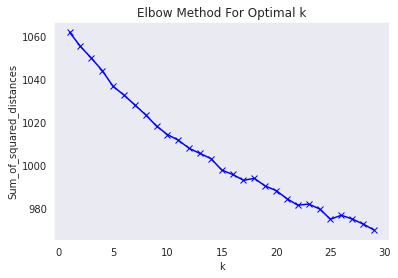

In [29]:
Sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For K')
plt.show()

In [37]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , n_jobs = -1
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

In [38]:
k = 15
kmeans_results = run_KMeans(k, X)


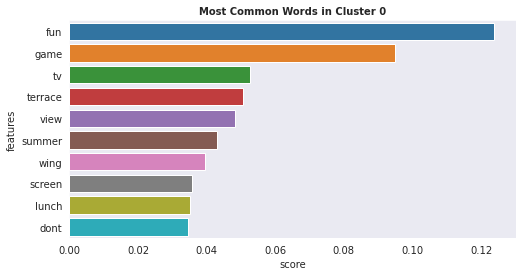

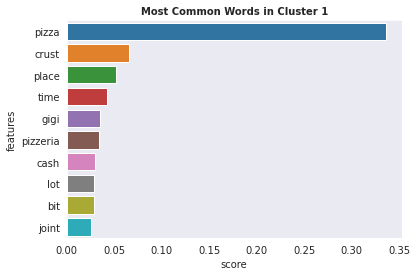

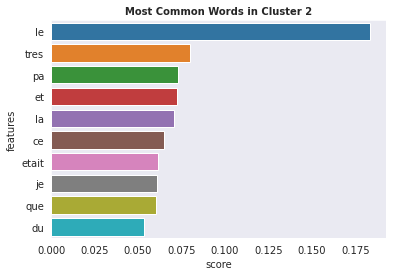

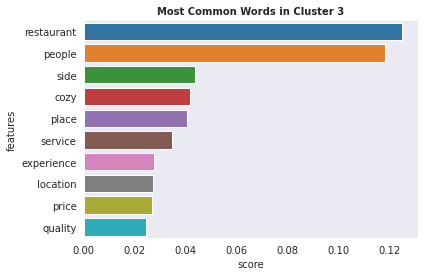

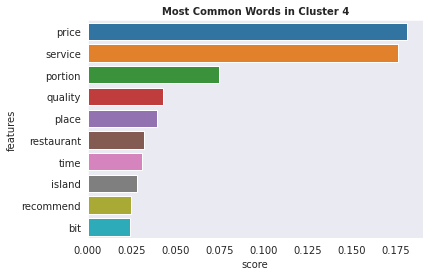

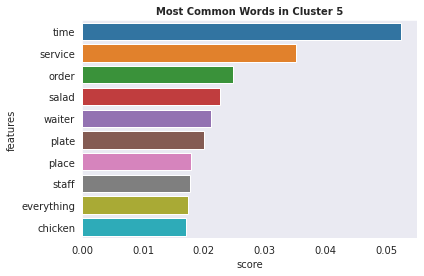

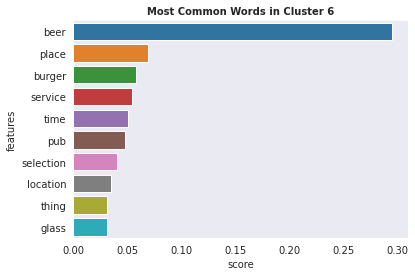

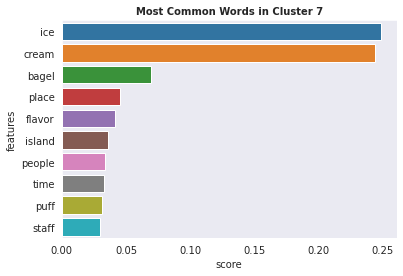

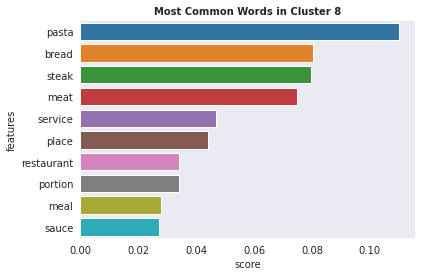

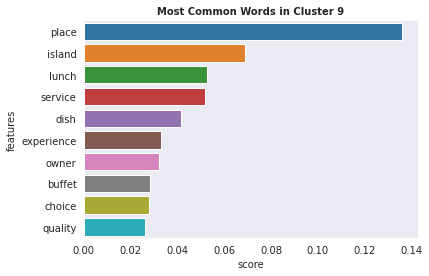

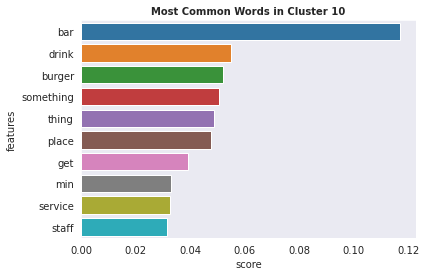

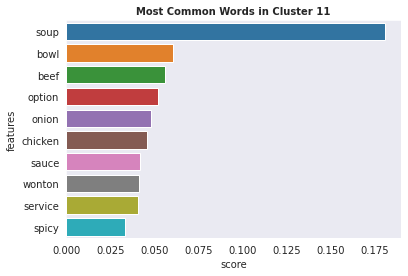

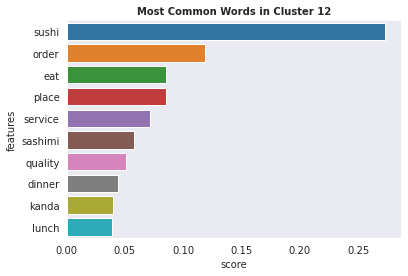

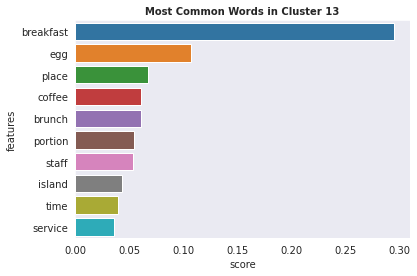

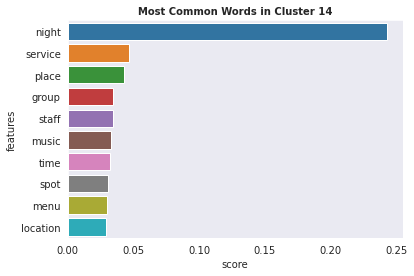

In [43]:

best_result = 15
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 10
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

In [42]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

In [44]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    
    x, y = np.ogrid[:300, :300]

    mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
    mask = 255 * mask.astype(int)
    wordcloud = WordCloud(max_font_size=100, background_color = 'white',mask=mask)
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

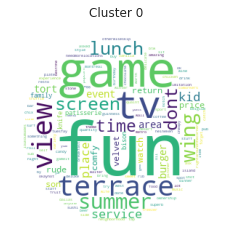

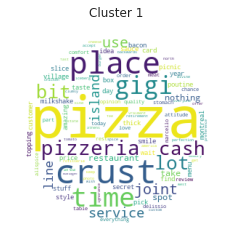

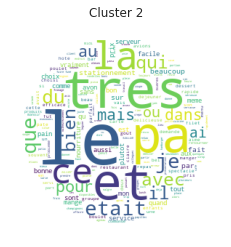

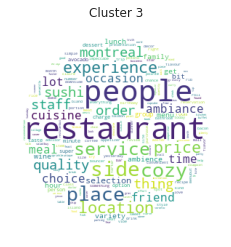

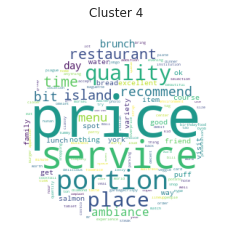

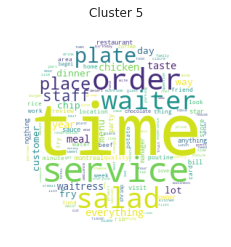

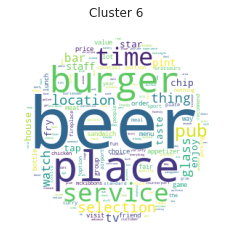

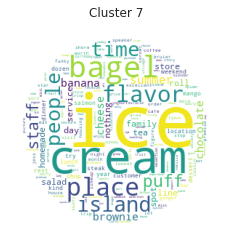

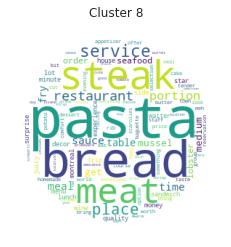

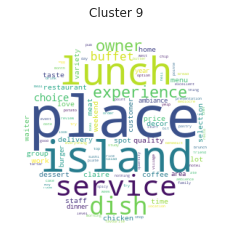

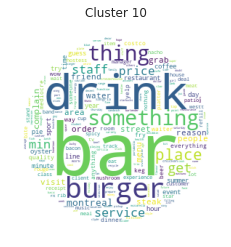

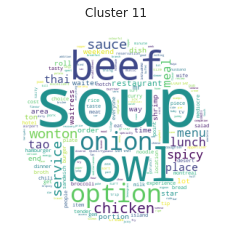

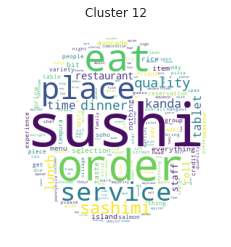

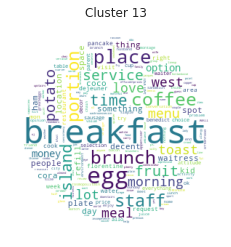

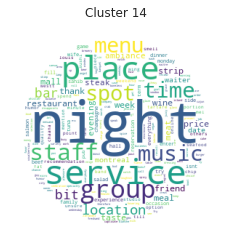

In [45]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

In [ ]:
labels = kmeans.labels_ 
PointeClaireQC_all['label'] = labels
PointeClaireQC_all.head()